# Exploration of ~2000 standard kanji and their grading levels

In [2]:
import pandas as pd
import json 
import codecs
import matplotlib.pyplot as plt 
import numpy as np
import os 

In [3]:
json_path = r".\kanji.json"

with codecs.open(json_path, mode='r', encoding='utf-8') as file:
    data = json.load(file)
    df = pd.DataFrame.from_dict(data)

df

,一,右,雨,円,王,音,下,火,花,貝,...,類,禮,曆,歷,練,鍊,郞,朗,廊,錄
character,一,右,雨,円,王,音,下,火,花,貝,...,類,禮,曆,歷,練,鍊,郞,朗,廊,錄
wk,1,2,5,2,2,5,1,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
joyo,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jlpt,N5,N5,N5,N5,N3,N4,N5,N5,N4,N2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,jōyō,jōyō,jōyō,jōyō,jōyō,jōyō,jōyō,jōyō,jōyō,jōyō,...,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō,jinmeiyō


In [8]:
def get_grade_counts(grades: pd.Series, normalize: bool, ax: plt.Axes=None) -> pd.Series:
    """Count kanji grades"""
    
    if normalize:
        return 100 * grades.value_counts() / grades.shape[0]
    else:
        return grades.value_counts()
        
def bin_wanikani_grades(grades: pd.Series, bin_size: int) -> pd.Series:
    """bin wanikani kanji in groups of bin_size"""
    
    if bin_size < 1: return grades 
    
    grades = pd.Series(np.sum( grades.values.reshape(10, -1), axis=0 ))
    grades.index = np.arange(1, 7)
    
    return grades 

def plot_grades(grades: pd.Series, grading_system: str, num_kanji: int) -> None:
    """Plot count or frequency of each grade level"""
    _, ax = plt.subplots(figsize=(8, 5))
    ax.set_xlabel(f'{grading_system} level')
    ax.set_title(f"{grading_system} total = {num_kanji}")
    
    xpos = np.arange(0, grades.shape[0])
    ax.bar(xpos, grades, 0.3)
    
    ax.set_xticks(xpos)
    ax.set_xticklabels(grades.index)
    plt.show()

def count_system_grades(data: pd.DataFrame, grading_system: str, 
               wanikani_bin_size=10, normalize=False, plot=True) -> pd.Series:
    
    if grading_system not in data.index:
        raise ValueError(f"{grading_system} not an available grading system.")
    
    # select grading system 
    grades = df.loc[grading_system, :].dropna()
    num_kanji = grades.shape[0]
    
    # count number of kanji per grade level
    grades = get_grade_counts(grades, normalize)
    
    # reorder columns
    if grading_system == 'jlpt':
        grades = grades.loc[['N1', 'N2', 'N3', 'N4', 'N5']]
    else:
        grades.index = grades.index.astype('int64')
        grades.sort_index(ascending=True, inplace=True)
        
    if grading_system == 'wk':
        grades = bin_wanikani_grades(grades, wanikani_bin_size)
    
    if plot: 
        plot_grades(grades, grading_system, num_kanji)
    
    return grades 

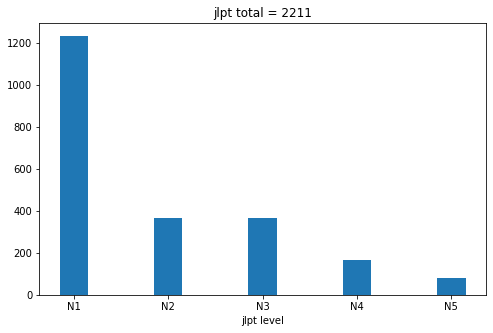

N1    1232
N2     367
N3     367
N4     166
N5      79
Name: jlpt, dtype: int64

In [9]:
count_system_grades(df, 'jlpt')

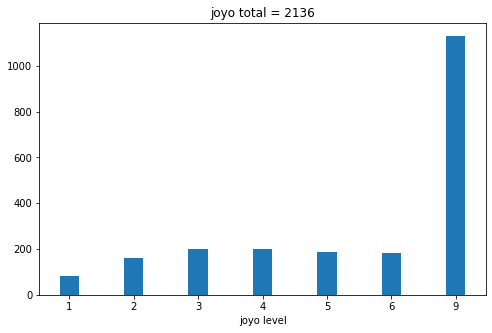

1      80
2     160
3     200
4     200
5     185
6     181
9    1130
Name: joyo, dtype: int64

In [10]:
count_system_grades(df, 'joyo')

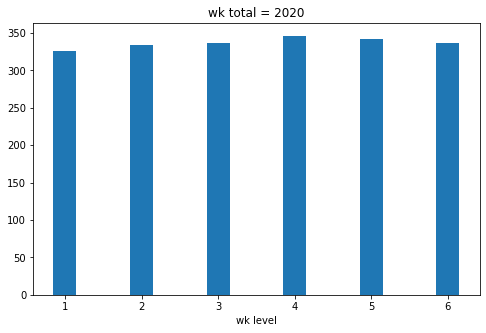

1    326
2    334
3    336
4    346
5    342
6    336
dtype: int64

In [11]:
count_system_grades(df, 'wk')

In [50]:
# format and save dataframe to parquet
def format_kanji_grades(df: pd.DataFrame, 
                        save_path=None, overwrite=True):
    
    df_save = df.T.set_index('character', drop=True)
    
    # numeric grade systems 
    num_sys = ['wk', 'joyo']
    df_save.loc[:, num_sys] = df_save.loc[:, num_sys].astype('float64')
    
    df_save.loc[:, 'jlpt'].replace(
        ['N1', 'N2', 'N3', 'N4', 'N5'], 
        list(range(1, 6)),
        inplace=True
    )
    
    if save_path is None:
        save_path = "./kanji_grades.parquet"

    isFile = os.path.isfile(save_path)
    if (not isFile) or (isFile and overwrite):
        df_save.to_parquet(save_path, engine='fastparquet')
        print(f"File saved to {save_path}")
        
    return df_save

In [51]:
format_kanji_grades(df, overwrite=True)

File saved to ./kanji_grades.parquet


,wk,joyo,jlpt,category
character,,,,
一,1,1,5.0,jōyō
右,2,1,5.0,jōyō
雨,5,1,5.0,jōyō
円,2,1,5.0,jōyō
王,2,1,3.0,jōyō
...,...,...,...,...
鍊,NaN,NaN,NaN,jinmeiyō
郞,NaN,NaN,NaN,jinmeiyō
朗,NaN,NaN,NaN,jinmeiyō
